<a href="https://colab.research.google.com/github/bagusangkasawan/CapstoneProjectLaskarAI/blob/main/ML/predict-rekomendasi-model/notebooks/EnergyMate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
# Manipulasi Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Normalisasi dan Splitting Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrik Evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tensorflow Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save and Load
from tensorflow.keras.models import load_model
import joblib

# Data Loading

In [ ]:
df = pd.read_csv('/content/household_power_consumption.csv', sep=";")
df

<ipython-input-6-2700d7ba6180>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/household_power_consumption.csv', sep=";")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


# Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


- Disini kalau tidak ingin menggunakan Datetime boleh dihapus saja
- Dataframe masih menggunakan format permenit

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df = df.dropna(subset=['Datetime'])
df.set_index('Datetime', inplace=True)

df.drop(columns=['Date', 'Time'], inplace=True)

df = df.apply(pd.to_numeric, errors='coerce')
df['hour'] = df.index.hour
df['days'] = df.index.dayofweek
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,days
Datetime,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,5
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,5
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,5
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,5
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,5


Missing Values & Duplicate Rows

In [ ]:
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
hour                         0
days                         0
dtype: int64

Duplicate Rows: 38702


In [ ]:
df = df.interpolate(method='time')
df = df.drop_duplicates()

print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
 Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
hour                     0
days                     0
dtype: int64

Duplicate Rows: 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   hour                   int32  
 8   days                   int32  
dtypes: float64(7), int32(2)
memory usage: 142.5 MB


# EDA

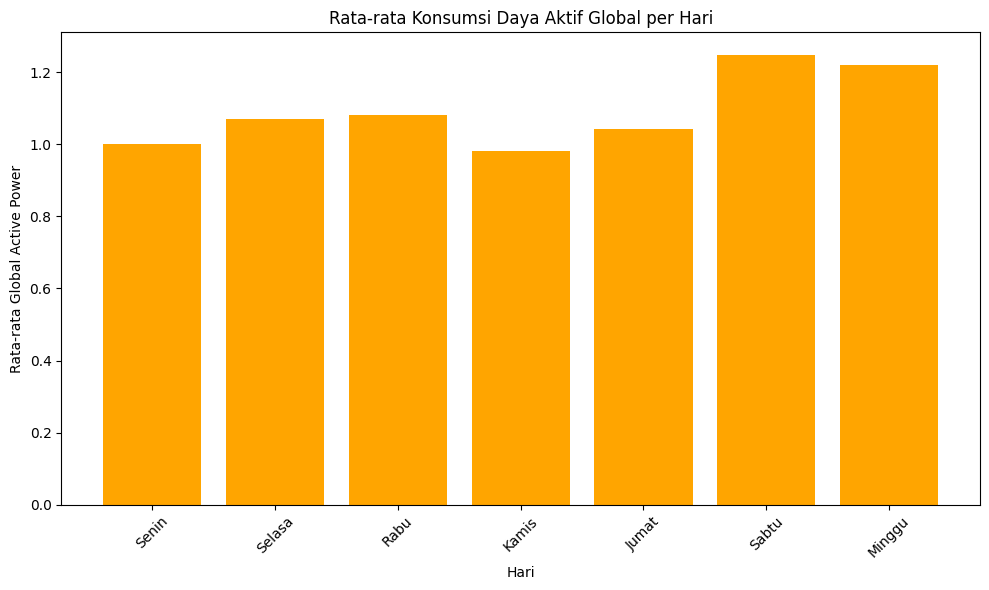

In [ ]:
day_names = {
    0: 'Senin',
    1: 'Selasa',
    2: 'Rabu',
    3: 'Kamis',
    4: 'Jumat',
    5: 'Sabtu',
    6: 'Minggu'
}

weekday_power = df.groupby('days')['Global_active_power'].mean()
weekday_power.index = weekday_power.index.map(day_names)

ordered_days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
weekday_power = weekday_power.reindex(ordered_days)

plt.figure(figsize=(10, 6))
plt.bar(weekday_power.index, weekday_power.values, color='orange')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Global Active Power')
plt.title('Rata-rata Konsumsi Daya Aktif Global per Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

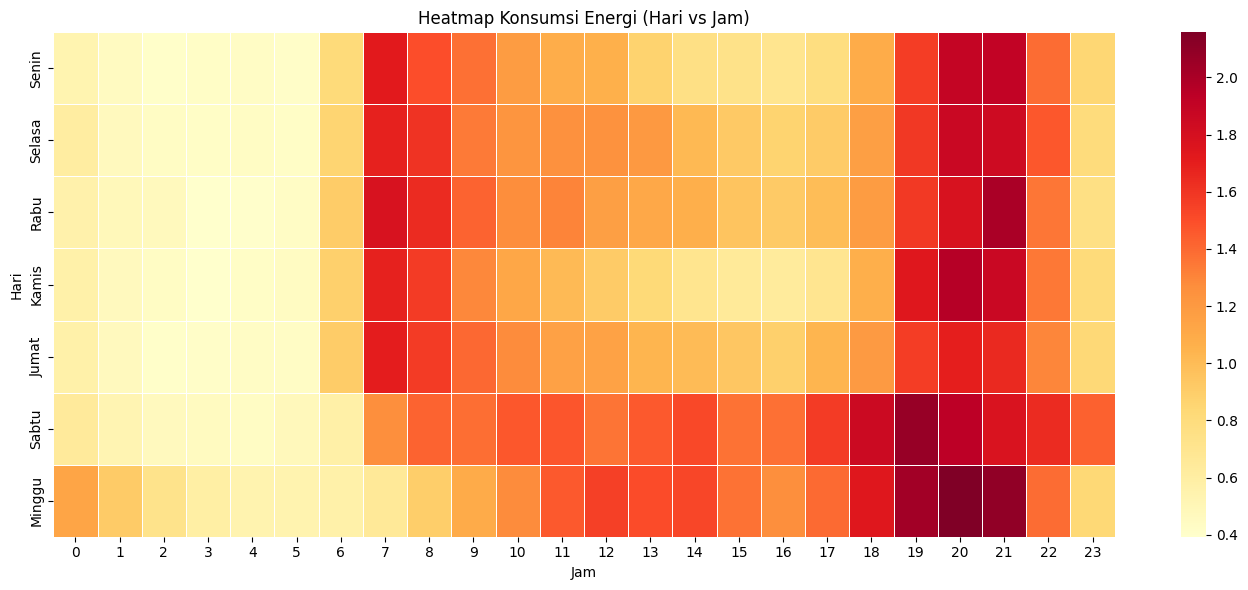

In [ ]:
heatmap_data = df.groupby(['days', 'hour'])['Global_active_power'].mean().unstack()
heatmap_data.index = heatmap_data.index.map(day_names)
heatmap_data = df.groupby(['days', 'hour'])['Global_active_power'].mean().unstack()

# Mapping index angka hari ke nama hari
heatmap_data.index = heatmap_data.index.map(day_names)

heatmap_data = heatmap_data.reindex(ordered_days)

# Visualisasi heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5)
plt.title("Heatmap Konsumsi Energi (Hari vs Jam)")
plt.xlabel("Jam")
plt.ylabel("Hari")
plt.tight_layout()
plt.show()

Rata-rata penggunan listrik di dapur per hari

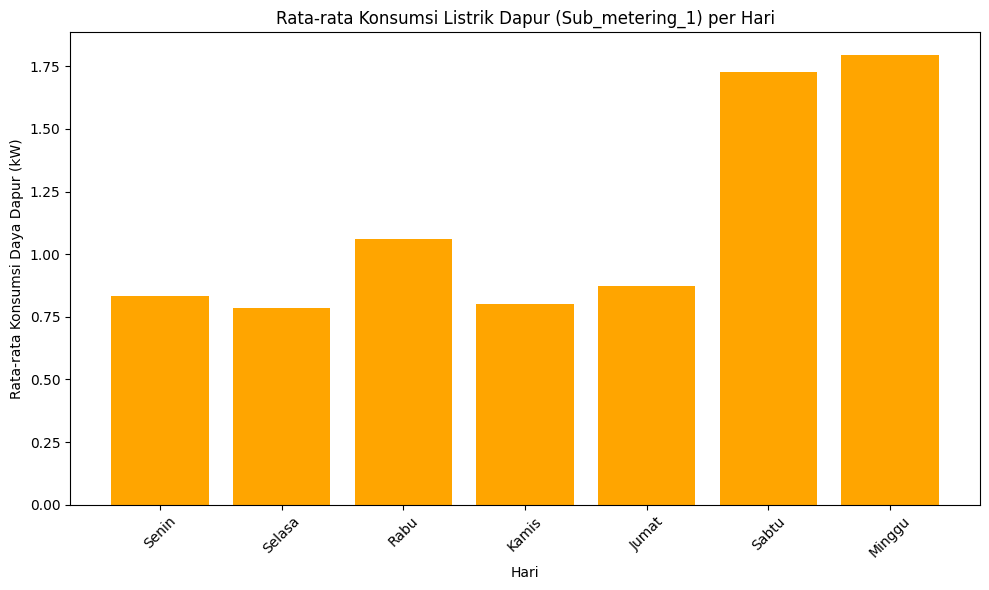

In [ ]:
kitchen_usage = df.groupby('days')['Sub_metering_1'].mean()

kitchen_usage.index = kitchen_usage.index.map(day_names)
kitchen_usage = kitchen_usage.reindex(ordered_days)

plt.figure(figsize=(10, 6))
plt.bar(kitchen_usage.index, kitchen_usage.values, color='orange')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Konsumsi Daya Dapur (kW)')
plt.title('Rata-rata Konsumsi Listrik Dapur (Sub_metering_1) per Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rata-rata penggunaan listrik untuk mencuci per hari

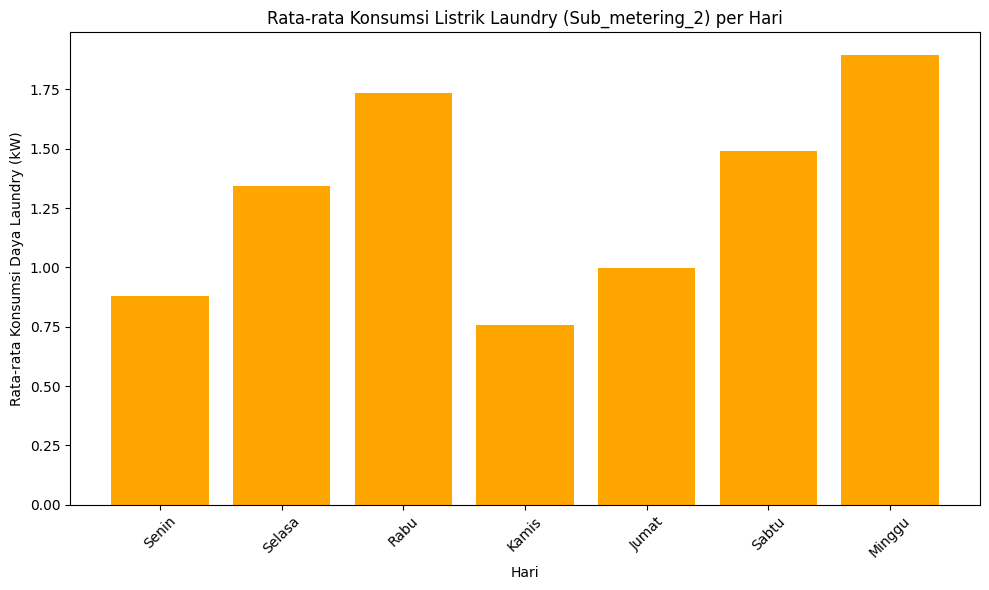

In [ ]:
laundry_usage = df.groupby('days')['Sub_metering_2'].mean()

laundry_usage.index = laundry_usage.index.map(day_names)
laundry_usage = laundry_usage.reindex(ordered_days)

plt.figure(figsize=(10, 6))
plt.bar(laundry_usage.index, laundry_usage.values, color='orange')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Konsumsi Daya Laundry (kW)')
plt.title('Rata-rata Konsumsi Listrik Laundry (Sub_metering_2) per Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rata-rata konsumsi Listrik Pendingin Ruangan

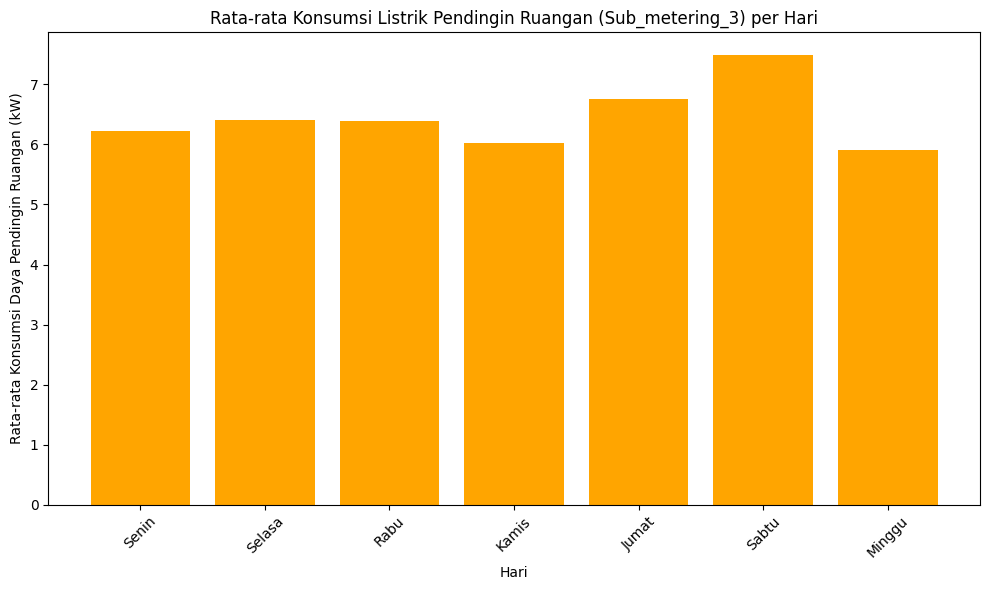

In [ ]:
ac_usage = df.groupby('days')['Sub_metering_3'].mean()

ac_usage.index = ac_usage.index.map(day_names)
ac_usage = ac_usage.reindex(ordered_days)

plt.figure(figsize=(10, 6))
plt.bar(ac_usage.index, ac_usage.values, color='orange')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Konsumsi Daya Pendingin Ruangan (kW)')
plt.title('Rata-rata Konsumsi Listrik Pendingin Ruangan (Sub_metering_3) per Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

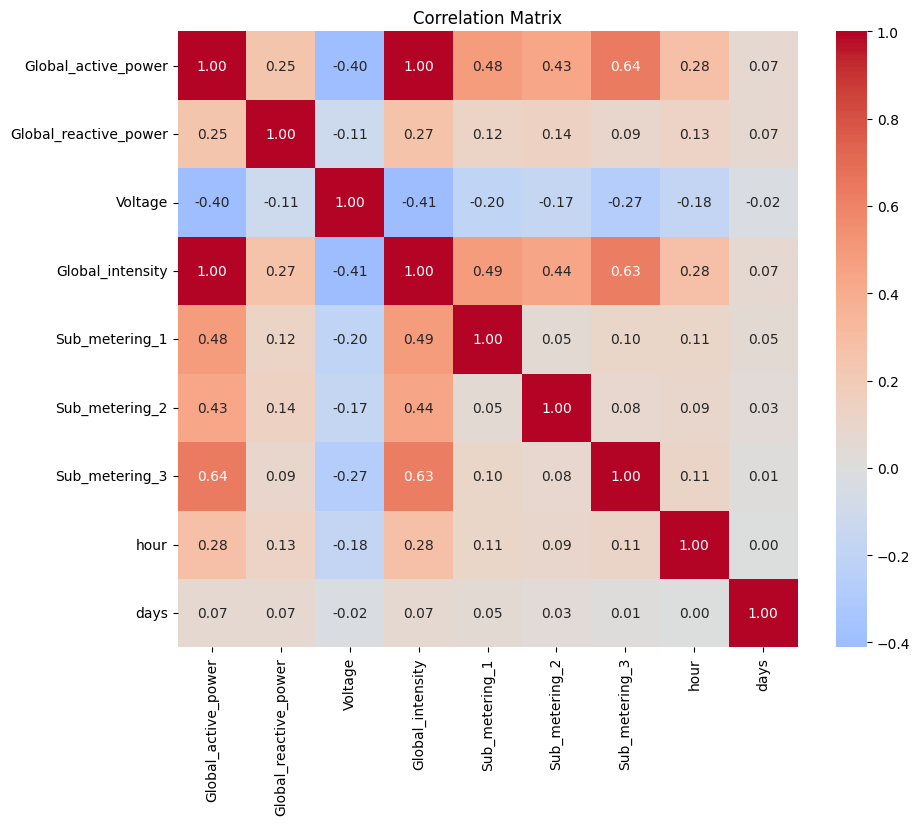

In [ ]:
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,        # tampilkan nilai korelasi di setiap cell
    fmt=".2f",         # format dua desimal
    cmap="coolwarm",   # palette warna
    center=0           # titik tengah nol
)
plt.title("Correlation Matrix")
plt.show()

# Data Preparation

In [ ]:
# Hapus outlier dari target (Global_active_power) --- gak jadi dihapus outliernya
Q1 = df['Global_active_power'].quantile(0.25)
Q3 = df['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
X = df[['Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour']]
y = df['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

joblib.dump(X_scaler, "X_scaler.save")
joblib.dump(y_scaler, "y_scaler.save")

print(f'Total keseluruhan data: {len(X)}')
print(f'Total keseluruhan data train: {len(X_train)}')
print(f'Total keseluruhan data validation: {len(X_val)}')
print(f'Total keseluruhan data test: {len(X_test)}')

Total keseluruhan data: 2075259
Total keseluruhan data train: 1328165
Total keseluruhan data validation: 332042
Total keseluruhan data test: 415052


# Modeling

Maka seq_length = 60 berarti model akan melihat satu jam

LSTM 60 MENIT

In [ ]:
# Fungsi untuk membuat sequences
def create_sequences(X, y, seq_length=60):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

# Buat sequences
seq_length = 60
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# Bangun model LSTM dengan Dropout
model = Sequential([
    LSTM(64, input_shape=(seq_length, X.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(X_train_seq, y_train_seq,
                    validation_data=(X_val_seq, y_val_seq),
                    epochs=50,
                    batch_size=128,
                    callbacks=[early_stop, checkpoint],
                    verbose=1)

# Prediksi & Evaluasi
y_pred = model.predict(X_test_seq)
mae = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"Test MAE   = {mae:.4f}")
print(f"Test RMSE  = {rmse:.4f}")
print(f"Test R²    = {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 0.0012 - mae: 0.0176 - val_loss: 4.7541e-04 - val_mae: 0.0103
Epoch 2/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 146s 11ms/step - loss: 6.6215e-04 - mae: 0.0126 - val_loss: 4.5654e-04 - val_mae: 0.0099
Epoch 3/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - loss: 6.3802e-04 - mae: 0.0123 - val_loss: 4.5495e-04 - val_mae: 0.0098
Epoch 4/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 131s 10ms/step - loss: 6.1321e-04 - mae: 0.0119 - val_loss: 4.6028e-04 - val_mae: 0.0102
Epoch 5/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 154s 11ms/step - loss: 6.0870e-04 - mae: 0.0119 - val_loss: 4.4667e-04 - val_mae: 0.0101
Epoch 6/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 5.9166e-04 - mae: 0.0117 - val_loss: 4.3008e-04 - val_mae: 0.0091
Epoch 7/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 152s 11ms/step - loss: 5.8234e-04 - mae: 0.0115 - val_loss: 4.3645e-04 - val_mae: 0.0097
Epoch 8/50
10312/10312 ━━━━━━━━━━━━━━━━━━━━ 145s 12ms/step - loss: 5.7152

In [ ]:
# Evaluasi data training
y_train_pred = model.predict(X_train_seq)
train_mae = mean_absolute_error(y_train_seq, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_seq, y_train_pred))
train_r2 = r2_score(y_train_seq, y_train_pred)

print("\n=== Evaluasi Training ===")
print(f"Train MAE  = {train_mae:.4f}")
print(f"Train RMSE = {train_rmse:.4f}")
print(f"Train R²   = {train_r2:.4f}")

# Evaluasi data testing
print("\n=== Evaluasi Testing ===")
print(f"Test MAE   = {mae:.4f}")
print(f"Test RMSE  = {rmse:.4f}")
print(f"Test R²    = {r2:.4f}")

41246/41246 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step

=== Evaluasi Training ===
Train MAE  = 0.0095
Train RMSE = 0.0223
Train R²   = 0.9506

=== Evaluasi Testing ===
Test MAE   = 0.0079
Test RMSE  = 0.0183
Test R²    = 0.9467


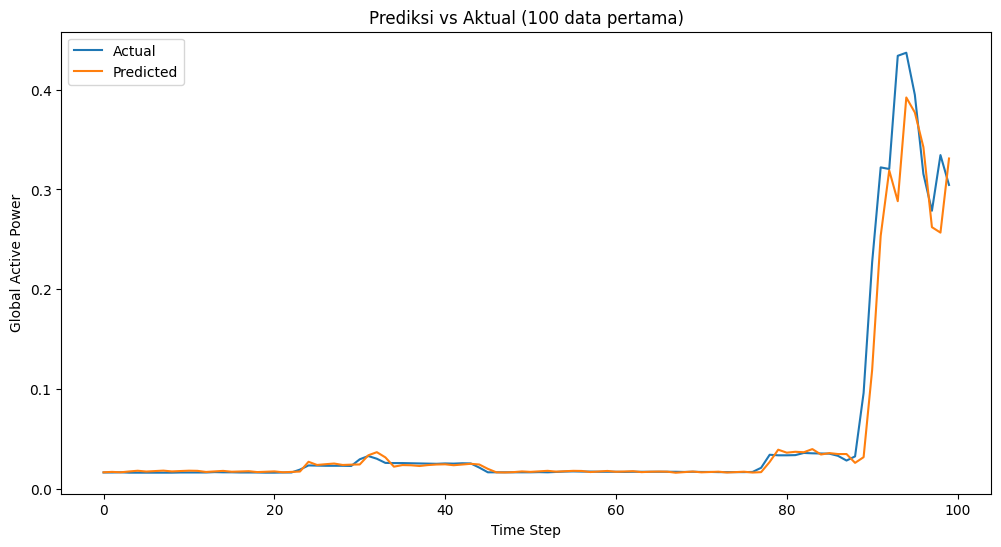

In [ ]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title("Prediksi vs Aktual (100 data pertama)")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()

**GRU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# GRU Model
model_gru = Sequential([
    GRU(64, input_shape=(seq_length, X.shape[1]), return_sequences=False),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
history_gru = model_gru.fit(X_train_seq, y_train_seq,
                            validation_data=(X_val_seq, y_val_seq),
                            epochs=50,
                            batch_size=256,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# Evaluation
y_pred_gru = model_gru.predict(X_test_seq)
mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_seq, y_pred_gru))
r2_gru = r2_score(y_test_seq, y_pred_gru)

print(f"[GRU] MAE   = {mae_gru:.4f}")
print(f"[GRU] RMSE  = {rmse_gru:.4f}")
print(f"[GRU] R²    = {r2_gru:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0030 - mae: 0.0312 - val_loss: 0.0010 - val_mae: 0.0154
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0012 - mae: 0.0174 - val_loss: 8.3080e-04 - val_mae: 0.0124
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - mae: 0.0166 - val_loss: 8.5721e-04 - val_mae: 0.0137
Epoch 4/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012 - mae: 0.0168 - val_loss: 8.1951e-04 - val_mae: 0.0126
Epoch 5/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - mae: 0.0160 - val_loss: 8.3876e-04 - val_mae: 0.0152
Epoch 6/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - mae: 0.0163 - val_loss: 8.2586e-04 - val_mae: 0.0132
Epoch 7/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011 - mae: 0.0160 - val_loss: 9.7540e-04 - val_mae: 0.0175
Epoch 8/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0011 - mae: 0.0163 - val_loss: 8.0531e-04 - val_mae: 0.0127
Epoch 9/50
445/445 ━━━━━━━━━

In [ ]:
# Evaluasi Training
y_train_pred_gru = model_gru.predict(X_train_seq)
train_mae_gru = mean_absolute_error(y_train_seq, y_train_pred_gru)
train_rmse_gru = np.sqrt(mean_squared_error(y_train_seq, y_train_pred_gru))
train_r2_gru = r2_score(y_train_seq, y_train_pred_gru)

# Evaluasi Testing
y_test_pred_gru = model_gru.predict(X_test_seq)
test_mae_gru = mean_absolute_error(y_test_seq, y_test_pred_gru)
test_rmse_gru = np.sqrt(mean_squared_error(y_test_seq, y_test_pred_gru))
test_r2_gru = r2_score(y_test_seq, y_test_pred_gru)

# Output hasil evaluasi
print("\n=== Evaluasi Training (GRU) ===")
print(f"Train MAE  = {train_mae_gru:.4f}")
print(f"Train RMSE = {train_rmse_gru:.4f}")
print(f"Train R²   = {train_r2_gru:.4f}")

print("\n=== Evaluasi Testing (GRU) ===")
print(f"Test MAE   = {test_mae_gru:.4f}")
print(f"Test RMSE  = {test_rmse_gru:.4f}")
print(f"Test R²    = {test_r2_gru:.4f}")

3555/3555 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

=== Evaluasi Training (GRU) ===
Train MAE  = 0.0133
Train RMSE = 0.0290
Train R²   = 0.9492

=== Evaluasi Testing (GRU) ===
Test MAE   = 0.0091
Test RMSE  = 0.0216
Test R²    = 0.9553


In [ ]:
# Prediksi GRU pada training set
y_train_pred_scaled = model_gru.predict(X_train_seq)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_train_true = y_scaler.inverse_transform(y_train_seq.reshape(-1, 1))

# Prediksi GRU pada testing set
y_test_pred_scaled = model_gru.predict(X_test_seq)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Evaluasi Training
mae_train = mean_absolute_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
r2_train = r2_score(y_train_true, y_train_pred)

print("TRAINING GRU")
print(f"MAE   = {mae_train:.4f}")
print(f"RMSE  = {rmse_train:.4f}")
print(f"R²    = {r2_train:.4f}\n")

# Evaluasi Testing
mae_test = mean_absolute_error(y_test_true, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
r2_test = r2_score(y_test_true, y_test_pred)

print("TESTING GRU")
print(f"MAE   = {mae_test:.4f}")
print(f"RMSE  = {rmse_test:.4f}")
print(f"R²    = {r2_test:.4f}")

3555/3555 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
TRAINING GRU
MAE   = 0.1396
RMSE  = 0.3034
R²    = 0.9492

TESTING GRU
MAE   = 0.0949
RMSE  = 0.2265
R²    = 0.9553


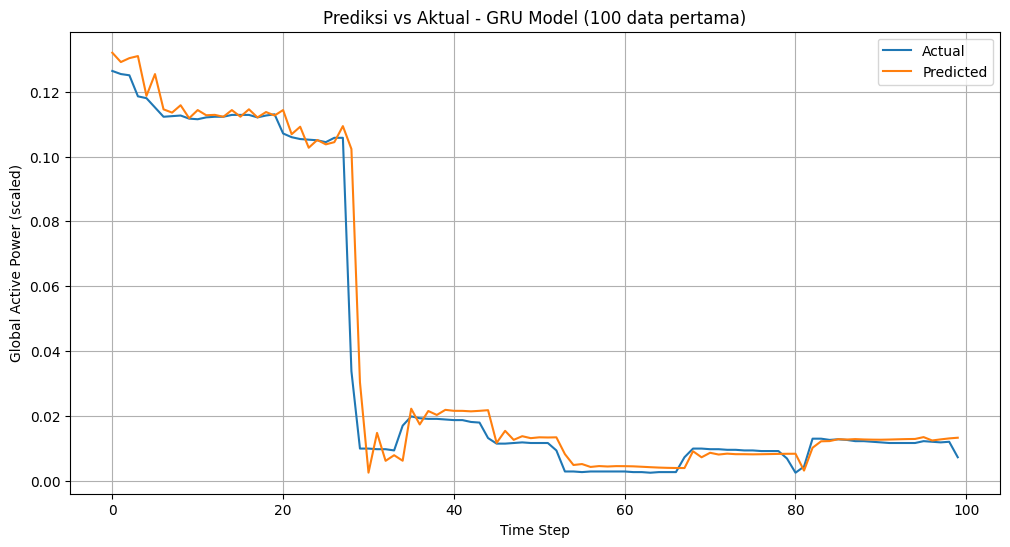

In [ ]:
# Visualisasi hasil prediksi GRU
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:100], label='Actual')
plt.plot(y_pred_gru[:100], label='Predicted')
plt.title("Prediksi vs Aktual - GRU Model (100 data pertama)")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power (scaled)")
plt.legend()
plt.grid(True)
plt.show()

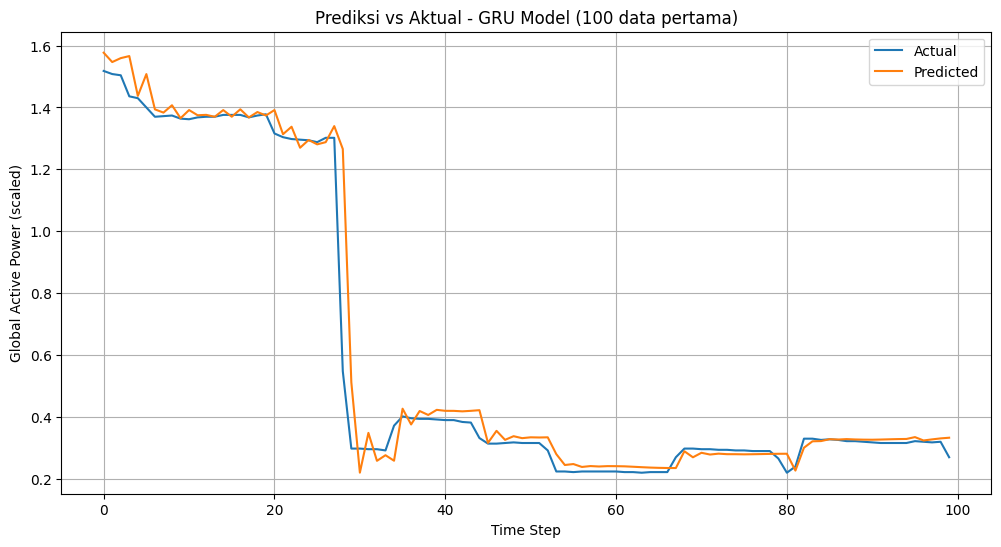

In [ ]:
y_test_seq_inv = y_scaler.inverse_transform(y_test_seq)
y_pred_gru_inv = y_scaler.inverse_transform(y_pred_gru)

# Visualisasi hasil prediksi GRU
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq_inv[:100], label='Actual')
plt.plot(y_pred_gru_inv[:100], label='Predicted')
plt.title("Prediksi vs Aktual - GRU Model (100 data pertama)")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power (scaled)")
plt.legend()
plt.grid(True)
plt.show()


**CNN-LSTM**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Bangun model CNN
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(seq_length, X.shape[1])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_cnn = model_cnn.fit(X_train_seq, y_train_seq,
                            validation_data=(X_val_seq, y_val_seq),
                            epochs=50,
                            batch_size=128,
                            callbacks=[early_stop],
                            verbose=1)

# Evaluasi Training
y_train_pred_cnn = model_cnn.predict(X_train_seq)
train_mae_cnn = mean_absolute_error(y_train_seq, y_train_pred_cnn)
train_rmse_cnn = np.sqrt(mean_squared_error(y_train_seq, y_train_pred_cnn))
train_r2_cnn = r2_score(y_train_seq, y_train_pred_cnn)

# Evaluasi Testing
y_test_pred_cnn = model_cnn.predict(X_test_seq)
test_mae_cnn = mean_absolute_error(y_test_seq, y_test_pred_cnn)
test_rmse_cnn = np.sqrt(mean_squared_error(y_test_seq, y_test_pred_cnn))
test_r2_cnn = r2_score(y_test_seq, y_test_pred_cnn)

# Print hasil evaluasi
print("\n=== Evaluasi Training (CNN) ===")
print(f"Train MAE  = {train_mae_cnn:.4f}")
print(f"Train RMSE = {train_rmse_cnn:.4f}")
print(f"Train R²   = {train_r2_cnn:.4f}")

print("\n=== Evaluasi Testing (CNN) ===")
print(f"Test MAE   = {test_mae_cnn:.4f}")
print(f"Test RMSE  = {test_rmse_cnn:.4f}")
print(f"Test R²    = {test_r2_cnn:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0041 - mae: 0.0354 - val_loss: 0.0011 - val_mae: 0.0169
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - mae: 0.0208 - val_loss: 0.0010 - val_mae: 0.0163
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0012 - mae: 0.0188 - val_loss: 9.8363e-04 - val_mae: 0.0168
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0011 - mae: 0.0174 - val_loss: 8.9757e-04 - val_mae: 0.0153
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0011 - mae: 0.0171 - val_loss: 9.1667e-04 - val_mae: 0.0156
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0010 - mae: 0.0162 - val_loss: 9.3481e-04 - val_mae: 0.0165
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0010 - mae: 0.0166 - val_loss: 8.4500e-04 - val_mae: 0.0144
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.5500e-04 - mae: 0.0158 - val_loss: 8.8044e-04 - val_mae: 0.0153
Epoch 9/50
889/889 ━━━━━━━━━

In [ ]:
# Inverse transform
y_train_seq_inv = y_scaler.inverse_transform(y_train_seq)
y_train_pred_inv = y_scaler.inverse_transform(y_train_pred_cnn)

y_test_seq_inv = y_scaler.inverse_transform(y_test_seq)
y_test_pred_inv = y_scaler.inverse_transform(y_test_pred_cnn)
train_mae_inv = mean_absolute_error(y_train_seq_inv, y_train_pred_inv)
train_rmse_inv = np.sqrt(mean_squared_error(y_train_seq_inv, y_train_pred_inv))
train_r2_inv = r2_score(y_train_seq_inv, y_train_pred_inv)

test_mae_inv = mean_absolute_error(y_test_seq_inv, y_test_pred_inv)
test_rmse_inv = np.sqrt(mean_squared_error(y_test_seq_inv, y_test_pred_inv))
test_r2_inv = r2_score(y_test_seq_inv, y_test_pred_inv)

print("\n=== Evaluasi Setelah Inverse - CNN ===")
print(f"Train MAE  = {train_mae_inv:.4f}")
print(f"Train RMSE = {train_rmse_inv:.4f}")
print(f"Train R²   = {train_r2_inv:.4f}")
print(f"Test MAE   = {test_mae_inv:.4f}")
print(f"Test RMSE  = {test_rmse_inv:.4f}")
print(f"Test R²    = {test_r2_inv:.4f}")



=== Evaluasi Setelah Inverse - CNN ===
Train MAE  = 0.1412
Train RMSE = 0.2947
Train R²   = 0.9520
Test MAE   = 0.0978
Test RMSE  = 0.2342
Test R²    = 0.9522


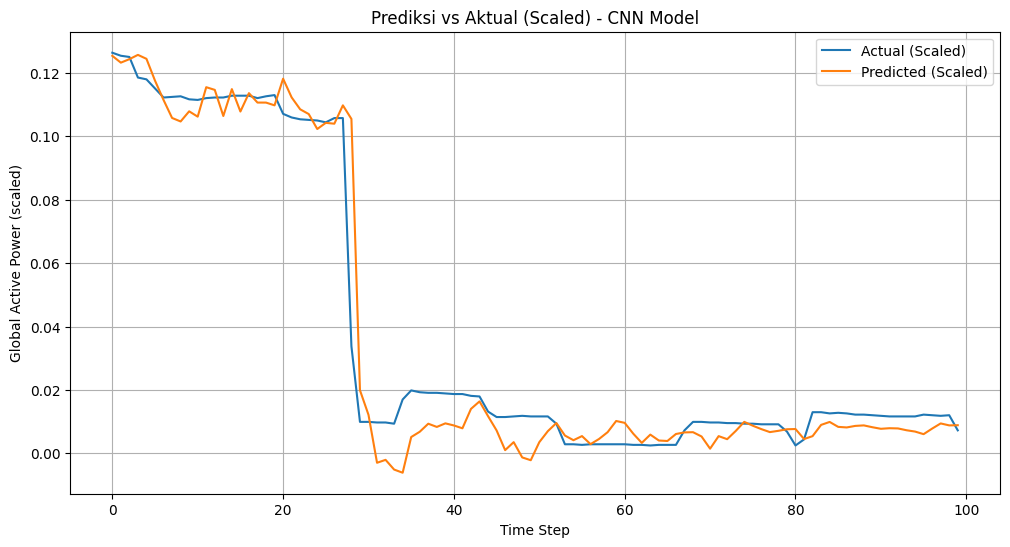

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:100], label='Actual (Scaled)')
plt.plot(y_test_pred_cnn[:100], label='Predicted (Scaled)')
plt.title("Prediksi vs Aktual (Scaled) - CNN Model")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power (scaled)")
plt.legend()
plt.grid(True)
plt.show()


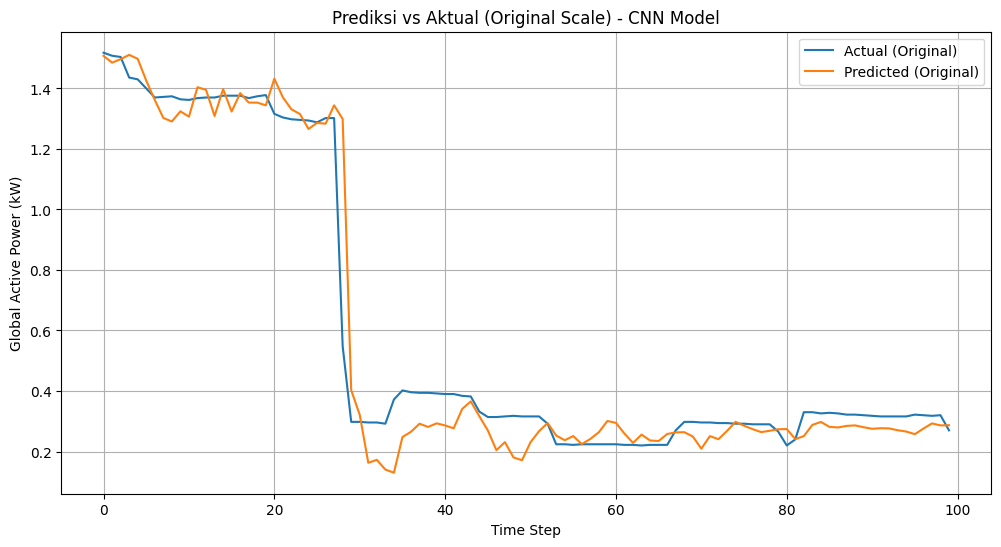

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq_inv[:100], label='Actual (Original)')
plt.plot(y_test_pred_inv[:100], label='Predicted (Original)')
plt.title("Prediksi vs Aktual (Original Scale) - CNN Model")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.show()


| Model    | Train MAE | Train RMSE | Train R²   | Test MAE   | Test RMSE  | Test R²    |
| -------- | --------- | ---------- | ---------- | ---------- | ---------- | ---------- |
| **LSTM** | 0.0095    | 0.0223     | 0.9506     | **0.0079** | 0.0183     | 0.9467     |
| **GRU**  | 0.0133    | 0.0290     | 0.9492     | 0.0091     | **0.0216** | **0.9553** |
| **CNN**  | 0.0135    | **0.0281** | **0.9520** | 0.0093     | 0.0224     | 0.9522     |


**Conclution:**

GRU memberikan prediksi paling stabil dan akurat secara keseluruhan di testing (lihat R² dan RMSE).

LSTM sangat dekat dengan GRU dan lebih baik dalam MAE testing.

CNN meskipun bukan yang terbaik di testing, tetap solid dan cepat dilatih — (berguna dalam implementasi nyata)

# Sistem Recommendation Rule Based

In [ ]:
model = load_model('best_model.keras')

In [ ]:
def get_user_consumption():
    try:
        global_intensity = float(input("Global Intensity (Ampere): "))
    except ValueError:
        print("Input tidak valid. Gunakan default 1.0 A.")
        global_intensity = 1.0

    appliance_power = {
        "microwave": 0.8,
        "rice cooker": 0.6,
        "blender": 0.3,
        "washing machine": 1.0,
        "dryer": 1.2,
        "iron": 1.1,
        "water heater": 1.5,
        "ac": 1.3,
        "vacuum cleaner": 0.9
    }

    appliance_to_sub = {
        "microwave": "Sub_metering_1", "rice cooker": "Sub_metering_1", "blender": "Sub_metering_1",
        "washing machine": "Sub_metering_2", "dryer": "Sub_metering_2", "iron": "Sub_metering_2",
        "water heater": "Sub_metering_3", "ac": "Sub_metering_3", "vacuum cleaner": "Sub_metering_3"
    }

    # inisialisasi total kWh per submeter
    submeter_usage = {"Sub_metering_1": 0.0, "Sub_metering_2": 0.0, "Sub_metering_3": 0.0}

    while True:
        item = input("Nama alat (atau ketik 'selesai'): ").strip().lower()
        if item == "selesai":
            break

        power = appliance_power.get(item, 0.02)
        if item not in appliance_power:
            print(f"Alat '{item}' tidak dikenali, gunakan daya default 0.02 kW.")

        # jumlah unit
        try:
            count = int(input(f"Jumlah unit '{item}': "))
            if count < 1:
                raise ValueError
        except ValueError:
            print("Jumlah tidak valid, gunakan default 1 unit.")
            count = 1

        # durasi jam
        try:
            hours = float(input(f"Durasi pemakaian '{item}' per unit (jam): "))
            if hours < 0:
                raise ValueError
        except ValueError:
            print("Durasi tidak valid, gunakan default 1 jam.")
            hours = 1.0

        # hitung energi
        energy_kwh = power * count * hours
        sub_key = appliance_to_sub.get(item, "Sub_metering_1")
        submeter_usage[sub_key] += energy_kwh
        print(f"► {item}: {count} × {power} kW × {hours} jam = {energy_kwh:.2f} kWh pada {sub_key}\n")

    try:
        hour = int(input("Jam sekarang (0-23): "))
        if hour < 0 or hour > 23:
            raise ValueError
    except ValueError:
        print("Input jam tidak valid. Gunakan default jam 12.")
        hour = 12

    return {
        "Global_intensity": global_intensity,
        "Sub_metering_1": round(submeter_usage["Sub_metering_1"], 2),
        "Sub_metering_2": round(submeter_usage["Sub_metering_2"], 2),
        "Sub_metering_3": round(submeter_usage["Sub_metering_3"], 2),
        "hour": hour
    }


In [ ]:
SUB_LABELS = {
    "Sub_metering_1": "Dapur",
    "Sub_metering_2": "Laundry",
    "Sub_metering_3": "Water Heater & AC"
}

def rule_based_recommendation(pred_kw, usage_kws):
    total_usage = sum(usage_kws.values())
    # cari submetering dengan penggunaan tertinggi
    max_sub = max(usage_kws, key=usage_kws.get)
    max_label = SUB_LABELS.get(max_sub, max_sub)

    # kategori berdasarkan distribusi (Q1/Q3 harus sudah didefinisikan)
    if pred_kw < 0.31:
        category = "Rendah"
        base_rec = "Konsumsi umum rendah—bagus, pertahankan pola ini."
    elif pred_kw <= 1.53:
        category = "Sedang"
        base_rec = "Konsumsi sedang—perhatikan peralatan yang tidak dipakai."
    else:
        category = "Tinggi"
        base_rec = "Konsumsi tinggi—kurangi beban puncak."

    # rekomendasi spesifik untuk submetering terberat
    specific_rec = (
        f"Bagian terberat berasal dari {max_label} "
        f"(≈{usage_kws[max_sub]:.2f} kWh). "
        f"Pertimbangkan mematikan atau mengurangi penggunaan peralatan di {max_label}."
    )

    return {
        "total_usage_kw": round(total_usage, 2),
        "prediction_kw": round(pred_kw, 2),
        "category": category,
        "breakdown": {SUB_LABELS[k]: round(v,2) for k,v in usage_kws.items()},
        "general_recommendation": base_rec,
        "focus_area": max_label,
        "specific_recommendation": specific_rec
    }

In [ ]:
X_scaled = joblib.load("X_scaler.save")
y_scaled = joblib.load("y_scaler.save")

def predict_and_recommend(user_input):

    X_input = np.array([[
        user_input["Global_intensity"],
        user_input["Sub_metering_1"],
        user_input["Sub_metering_2"],
        user_input["Sub_metering_3"],
        user_input["hour"]
    ]])

    X_scaled = X_scaler.transform(X_input)

    seq_length = 48
    X_seq = np.zeros((1, seq_length, X_scaled.shape[1]))
    X_seq[0, -1, :] = X_scaled[0]

    prediction_scaled = model.predict(X_seq, verbose=0)[0][0]

    prediction_kw = y_scaler.inverse_transform([[prediction_scaled]])[0][0]

    usage_kws = {
        "Sub_metering_1": user_input["Sub_metering_1"],
        "Sub_metering_2": user_input["Sub_metering_2"],
        "Sub_metering_3": user_input["Sub_metering_3"]
    }

    result = rule_based_recommendation(prediction_kw, usage_kws)
    return result

In [ ]:
user_input = get_user_consumption()
result = predict_and_recommend(user_input)
print(result)

Global Intensity (Ampere): 25
Nama alat (atau ketik 'selesai'): microwave
Jumlah unit 'microwave': 3
Durasi pemakaian 'microwave' per unit (jam): 1
► microwave: 3 × 0.8 kW × 1.0 jam = 2.40 kWh pada Sub_metering_1

Nama alat (atau ketik 'selesai'): ac
Jumlah unit 'ac': 1
Durasi pemakaian 'ac' per unit (jam): 4
► ac: 1 × 1.3 kW × 4.0 jam = 5.20 kWh pada Sub_metering_3

Nama alat (atau ketik 'selesai'): washing machine
Jumlah unit 'washing machine': 1
Durasi pemakaian 'washing machine' per unit (jam): 2
► washing machine: 1 × 1.0 kW × 2.0 jam = 2.00 kWh pada Sub_metering_2

Nama alat (atau ketik 'selesai'): selesai
Jam sekarang (0-23): 23
{'total_usage_kw': 9.6, 'prediction_kw': np.float64(5.29), 'category': 'Tinggi', 'breakdown': {'Dapur': 2.4, 'Laundry': 2.0, 'Water Heater & AC': 5.2}, 'general_recommendation': 'Konsumsi tinggi—kurangi beban puncak.', 'focus_area': 'Water Heater & AC', 'specific_recommendation': 'Bagian terberat berasal dari Water Heater & AC (≈5.20 kWh). Pertimbangkan 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
